# Internet of Things
#### 25th of May 2020
### Gianmaria Carnazzi, Giulio Mantoan, Giacomo Miolo, Paolo Ticozzi

## Importing Libraries

In [1]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import glob

# Visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette('Set1')
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import plotly.express as px
import matplotlib.dates as mdates

# Missing Values
import missingno as msno

# Stats
from scipy.stats import skew, kurtosis

# Dates
from datetime import datetime, date, time

import json
from IPython.display import Image


## IoT Lab Map with Sensor Location

In [2]:
# PATH = "/Users/giacomomiolo/Projects/IoT Light Sensors/"
PATH = "C:/Users/giuma/Dropbox/MIP/Material/9) ANALYTICS FOR MANAGEMENT/IoT & Big Data/Garavaglia/"

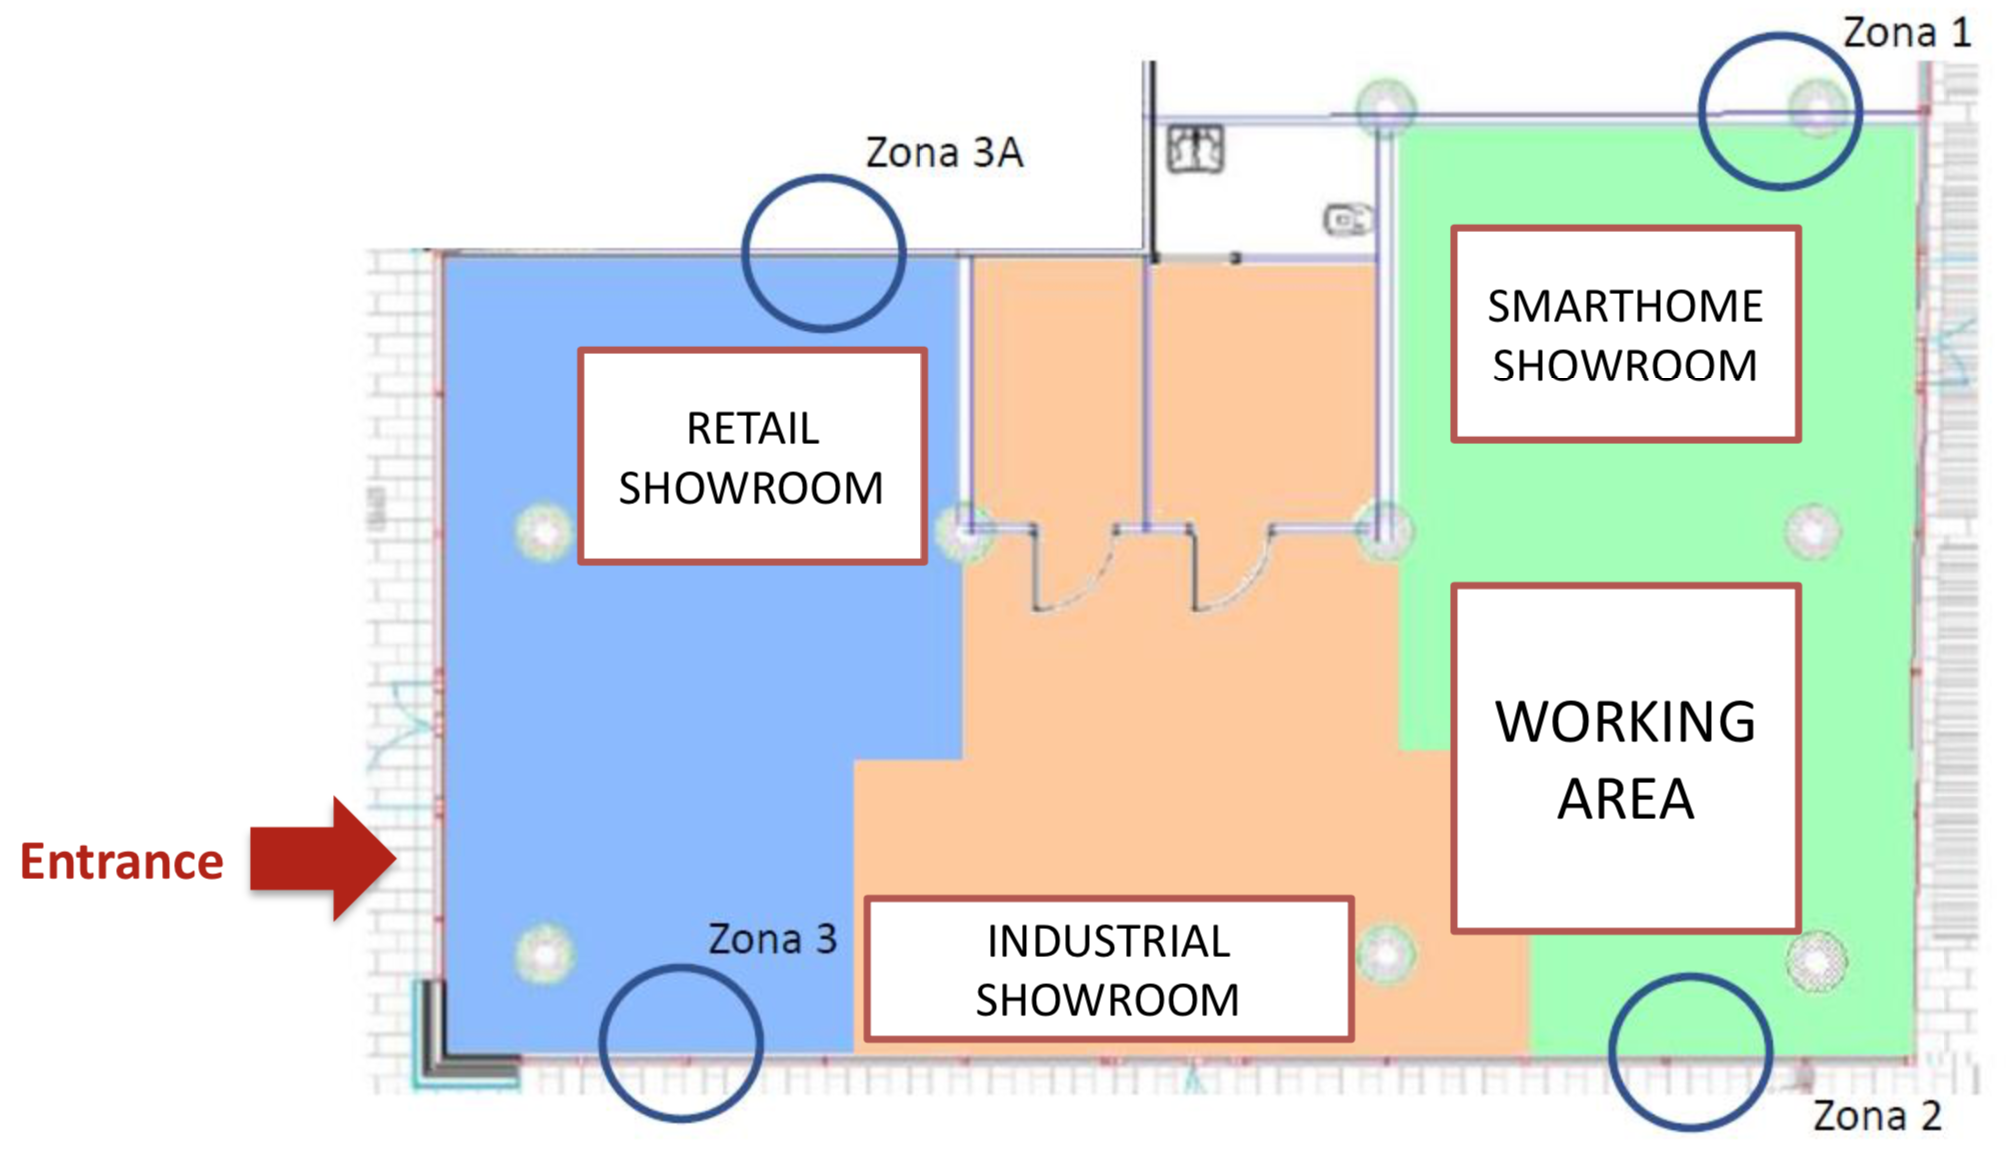

In [3]:
Image(PATH + "map.png")

## Current Setup

### Lights: 
- Currently employed are 12 fixtures x 4 neon lights each, 48 neon lights total
- Each neon light consumes 30 W, not dimmable

### Curtains:
- Manual
- Can be set on one of three levels that filter respectively 0, 30 and 60% of outdoor light

### Schedule:
- Both lights and curtains are following a **weekly** schedule.
- Curtains position is decided during the weekend and cannot be changed during the week.
- Can schedule an **hourly** routine for the lights during the weekend and cannot be changed during the week.
- Can't make different schedules for different Lab Zones, only a single schedule for the whole lab.

## Importing Data

In [4]:
# Listing all csv in the directory
files = []
for csv in glob.glob(PATH + '*.csv'):
#     files.append(csv.split("/")[-1])
    files.append(csv.split("\\")[-1])
files

['babd_light_z1.csv',
 'babd_light_z2.csv',
 'babd_light_z3.csv',
 'babd_light_z3A.csv',
 'babd_movement_z1.csv',
 'babd_movement_z2.csv',
 'babd_movement_z3.csv',
 'babd_movement_z3A.csv',
 'milan_weather_hourly.csv']

In [5]:
# Light
z3a = pd.read_csv(PATH + "babd_light_z3A.csv", sep="\t")
z1 = pd.read_csv(PATH + "babd_light_z1.csv", sep="\t")
z2 = pd.read_csv(PATH + "babd_light_z2.csv", sep="\t")
z3 = pd.read_csv(PATH + "babd_light_z3.csv", sep="\t")

# Movement
mov_z1 = pd.read_csv(PATH + "babd_movement_z1.csv", sep="\t")
mov_z2 = pd.read_csv(PATH + "babd_movement_z2.csv", sep="\t")
mov_z3 = pd.read_csv(PATH + "babd_movement_z3.csv", sep="\t")
mov_z3a = pd.read_csv(PATH + 'babd_movement_z3A.csv', sep="\t")

# Past Weather Data
weather = pd.read_csv(PATH + "milan_weather_hourly.csv", index_col=0)

#### Weather Past Data - Hourly - World Weather Online API

In [6]:
# Weather Past Data - From 25/02/2019 to 25/03/2019
# Data was taken from World Weather Online API.
# Query: https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=MYAPIKEY&q=Milan&format=json&date=2019-02-25&enddate=2019-03-25&tp=1

with open(PATH + "milan_hourly_weather.json") as json_file:
    json_weather = json.load(json_file)

In [7]:
weather_hourly = pd.json_normalize(data = json_weather['data']['weather'], # json_weather['weather'], #
                                record_path = ['hourly'],
                                meta = ['date'])

In [8]:
weather_hourly = weather_hourly[['date', 'time', 'tempC', 'windspeedKmph', 'cloudcover', 'uvIndex', 'weatherDesc']]

bad_format = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900',
       '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700',
       '1800', '1900', '2000', '2100', '2200', '2300']
correct_format = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23']
weather_hourly['time'].replace(to_replace=bad_format, value=correct_format, inplace=True)

weather_hourly['date'] = weather_hourly['date'] + " " + weather_hourly['time']
weather_hourly['date'] = pd.to_datetime(weather_hourly['date'], format='%Y-%m-%d %H')
weather_hourly.drop('time', axis=1, inplace=True)

In [9]:
weather_hourly.head()

,date,tempC,windspeedKmph,cloudcover,uvIndex,weatherDesc
0,2019-02-25 00:00:00,6,7,5,1,[{'value': 'Partly cloudy'}]
1,2019-02-25 01:00:00,6,6,5,1,[{'value': 'Partly cloudy'}]
2,2019-02-25 02:00:00,6,5,4,1,[{'value': 'Partly cloudy'}]
3,2019-02-25 03:00:00,7,4,4,1,[{'value': 'Partly cloudy'}]
4,2019-02-25 04:00:00,7,4,3,1,[{'value': 'Partly cloudy'}]


In [10]:
weather_str = pd.json_normalize(data = json_weather['data']['weather'], # json_weather['weather'], #
                                record_path =['hourly', 'weatherDesc'])
weather_hourly['weather'] = weather_str['value']
weather_hourly.drop('weatherDesc', axis=1, inplace=True)

In [11]:
weather_hourly.head(10)

,date,tempC,windspeedKmph,cloudcover,uvIndex,weather
0,2019-02-25 00:00:00,6,7,5,1,Partly cloudy
1,2019-02-25 01:00:00,6,6,5,1,Partly cloudy
2,2019-02-25 02:00:00,6,5,4,1,Partly cloudy
3,2019-02-25 03:00:00,7,4,4,1,Partly cloudy
4,2019-02-25 04:00:00,7,4,3,1,Partly cloudy
5,2019-02-25 05:00:00,7,4,3,1,Partly cloudy
6,2019-02-25 06:00:00,7,4,2,3,Partly cloudy
7,2019-02-25 07:00:00,8,4,2,3,Partly cloudy
8,2019-02-25 08:00:00,9,4,1,3,Partly cloudy
9,2019-02-25 09:00:00,9,5,1,3,Partly cloudy


In [12]:
# Uncomment to save for easier input, this is how the file was obtained.
# weather_hourly.to_csv('milan_weather_hourly.csv')

### Weather Forecast Data - Every 3 hours - Given Dataset

In [13]:
# Weather Forecast Data
# Data was provided

with open(PATH + "forecast.json") as json_file:
    forecast_json = json.load(json_file)

In [14]:
forecast = pd.DataFrame(forecast_json['list'])
forecast.drop(['dt','sys'], axis = 1, inplace=True)

w, d, a = [], [], []

for i in forecast.index:
    w.append(forecast.iloc[:,1][i][0]['main'])
    d.append(forecast.iloc[:,4][i])
    a.append(forecast.iloc[:,2][i]['all'])
    
mydict = {'timestamp': d, 'weather': w, 'clouds_level': a}
given_forecast = pd.DataFrame(mydict)  
given_forecast['timestamp'] = pd.to_datetime(given_forecast['timestamp'])

In [15]:
given_forecast.head()

,timestamp,weather,clouds_level
0,2019-04-01 06:00:00,Clear,0
1,2019-04-01 09:00:00,Clear,8
2,2019-04-01 12:00:00,Clouds,44
3,2019-04-01 15:00:00,Clouds,68
4,2019-04-01 18:00:00,Clouds,48


### Weather Forecast Data - Hourly - World Weather Online API

In [16]:
# Weather Forecast Data - From 01/04/2019 to 05/04/2019
# Data was taken from World Weather Online API.
# Query: https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=MYAPIKEY&q=Milan&format=json&date=2019-04-01&enddate=2019-04-05&tp=1

with open(PATH + "forecast_weather_api.json") as json_file:
    forecast_json_api = json.load(json_file)

In [17]:
forecast_hourly = pd.json_normalize(data = forecast_json_api['weather'],
                                record_path = ['hourly'],
                                meta = ['date'])

In [18]:
forecast_hourly = forecast_hourly[['date', 'time', 'tempC', 'windspeedKmph', 'cloudcover', 'uvIndex', 'weatherDesc']]

forecast_hourly['time'].replace(to_replace=bad_format, value=correct_format, inplace=True)

forecast_hourly['date'] = forecast_hourly['date'] + " " + forecast_hourly['time']
forecast_hourly['date'] = pd.to_datetime(forecast_hourly['date'], format='%Y-%m-%d %H')
forecast_hourly.drop('time', axis=1, inplace=True)

In [19]:
forecast_hourly.head()

,date,tempC,windspeedKmph,cloudcover,uvIndex,weatherDesc
0,2019-04-01 00:00:00,17,2,1,1,[{'value': 'Partly cloudy'}]
1,2019-04-01 01:00:00,16,2,3,1,[{'value': 'Partly cloudy'}]
2,2019-04-01 02:00:00,15,2,6,1,[{'value': 'Clear'}]
3,2019-04-01 03:00:00,14,3,9,1,[{'value': 'Clear'}]
4,2019-04-01 04:00:00,13,3,13,1,[{'value': 'Clear'}]


In [20]:
weather_str = pd.json_normalize(data = forecast_json_api['weather'],
                                record_path =['hourly', 'weatherDesc'])
forecast_hourly['weather'] = weather_str['value']
forecast_hourly.drop('weatherDesc', axis=1, inplace=True)
forecast_hourly.cloudcover = forecast_hourly.cloudcover.astype(float)

In [21]:
forecast_hourly.head(10)

,date,tempC,windspeedKmph,cloudcover,uvIndex,weather
0,2019-04-01 00:00:00,17,2,1.0,1,Partly cloudy
1,2019-04-01 01:00:00,16,2,3.0,1,Partly cloudy
2,2019-04-01 02:00:00,15,2,6.0,1,Clear
3,2019-04-01 03:00:00,14,3,9.0,1,Clear
4,2019-04-01 04:00:00,13,3,13.0,1,Clear
5,2019-04-01 05:00:00,13,3,17.0,1,Partly cloudy
6,2019-04-01 06:00:00,12,4,21.0,4,Partly cloudy
7,2019-04-01 07:00:00,14,4,18.0,4,Partly cloudy
8,2019-04-01 08:00:00,15,4,15.0,4,Partly cloudy
9,2019-04-01 09:00:00,16,4,12.0,5,Partly cloudy


In [22]:
# Uncomment to save for easier input, this is how the file was obtained.
# forecast_hourly.to_csv('milan_forecast_hourly.csv')

### Comparison between given weather data and data from World Weather API

In [23]:
given_forecast.index = given_forecast.timestamp
given_forecast_hourly = given_forecast\
                                      .resample('60min')\
                                      .agg({'clouds_level':'mean'})\
                                      .fillna(method='ffill')\
                                      .reset_index()

In [24]:
given_forecast_hourly = given_forecast_hourly.set_index('timestamp')
forecast_hourly = forecast_hourly.set_index('date')

In [25]:
sorted_date = np.sort(given_forecast_hourly.index)
timedelta_ns = sorted_date[-1] - sorted_date[0]
timedelta_days = timedelta_ns.astype('timedelta64[s]')

print('--- Given Weather Data ---')
print(f"First date included: {np.datetime_as_string(sorted_date[0], unit='s')}")
print(f"Last date included: {np.datetime_as_string(sorted_date[-1], unit='s')}")
print(f"Time interval considered: {timedelta_days.item().days} days.")

--- Given Weather Data ---
First date included: 2019-04-01T06:00:00
Last date included: 2019-04-05T21:00:00
Time interval considered: 4 days.


In [26]:
sorted_date = np.sort(forecast_hourly.index)
timedelta_ns = sorted_date[-1] - sorted_date[0]
timedelta_days = timedelta_ns.astype('timedelta64[s]')

print('--- Data from World Weather API ---')
print(f"First date included: {np.datetime_as_string(sorted_date[0], unit='s')}")
print(f"Last date included: {np.datetime_as_string(sorted_date[-1], unit='s')}")
print(f"Time interval considered: {timedelta_days.item().days} days.")

--- Data from World Weather API ---
First date included: 2019-04-01T00:00:00
Last date included: 2019-04-05T23:00:00
Time interval considered: 4 days.


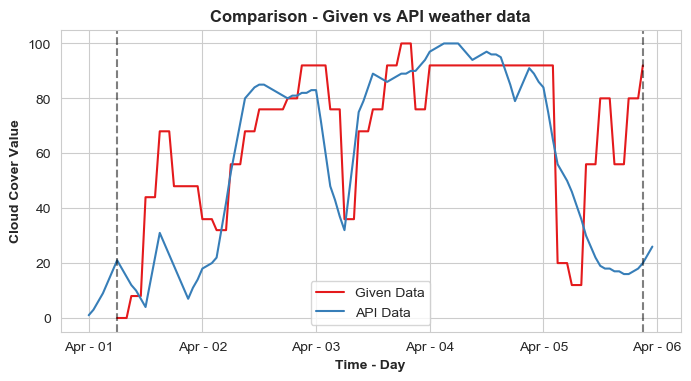

In [27]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.plot(given_forecast_hourly.index, given_forecast_hourly.iloc[:,0], linestyle='-', marker='', label='Given Data')
ax.plot(forecast_hourly.index, forecast_hourly.iloc[:,2], linestyle='-', marker='', label='API Data')

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)

days_format = mdates.DateFormatter('%b - %d')
hours_format = mdates.DateFormatter('%H')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)
plt.ylim(-5, 105)

# First and Last timestamp of given dataset
ax.axvline(given_forecast_hourly.index[0], linestyle='--', color='black', alpha = 0.5)
ax.axvline(given_forecast_hourly.index[-1], linestyle='--', color='black', alpha = 0.5)


ax.set_xlabel("Time - Day", fontweight='bold')
ax.set_ylabel("Cloud Cover Value", fontweight='bold')
plt.title('Comparison - Given vs API weather data', fontweight='bold')
plt.legend()
plt.show()

We can conclude that the data provided was taken from a different API, however, given that the values don't seem to differ too much, we consider the API as reliable for the purpose of providing weather data about the previous data points.

## Exploratory Data Analysis

In [28]:
z1.head()

,timestamp,zone,sensor,id,value,unit_of_measure
0,2019-02-25 01:00:00,1,LDR,1,12,pitic
1,2019-02-25 01:00:20,1,LDR,1,19,pitic
2,2019-02-25 01:00:40,1,LDR,1,19,pitic
3,2019-02-25 01:01:00,1,LDR,1,18,pitic
4,2019-02-25 01:01:20,1,LDR,1,18,pitic


In [29]:
mov_z1.head()

,timestamp,zone,sensor,id,n_passages
0,2019-03-01 09:45:33,1,PIR,1,1
1,2019-03-01 09:45:37,1,PIR,1,1
2,2019-03-01 09:45:46,1,PIR,1,1
3,2019-03-01 09:46:49,1,PIR,1,1
4,2019-03-01 09:46:53,1,PIR,1,1


In [30]:
def prep_light(df):
    df['timestamp'] =  pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.drop(['unit_of_measure'], axis=1, inplace=True)
    return

def prep_people(df):
    df['timestamp'] =  pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    return

In [31]:
prep_light(z1)
prep_light(z2)
prep_light(z3)
prep_light(z3a)

prep_people(mov_z1)
prep_people(mov_z2)
prep_people(mov_z3)
prep_people(mov_z3a)

# Setting different levels to better visualize number of passages
mov_z1['n_passages'] *= 150
mov_z2['n_passages'] *= 200
mov_z3['n_passages'] *= 250
mov_z3a['n_passages'] *= 300

### Single Day Visualized

In [32]:
date_start = '2019-03-07 0:00:00'
date_end = '2019-03-08 00:00:00'

mask_z1 = (z1.index > date_start) & (z1.index < date_end)
mask_z2 = (z2.index > date_start) & (z2.index < date_end)
mask_z3 = (z3.index > date_start) & (z3.index < date_end)
mask_z3a = (z3a.index > date_start) & (z3a.index < date_end)

mask_mov_z1 = (mov_z1.index > date_start) & (mov_z1.index < date_end)
mask_mov_z2 = (mov_z2.index > date_start) & (mov_z2.index < date_end)
mask_mov_z3 = (mov_z3.index > date_start) & (mov_z3.index < date_end)
mask_mov_z3a = (mov_z3a.index > date_start) & (mov_z3a.index < date_end)

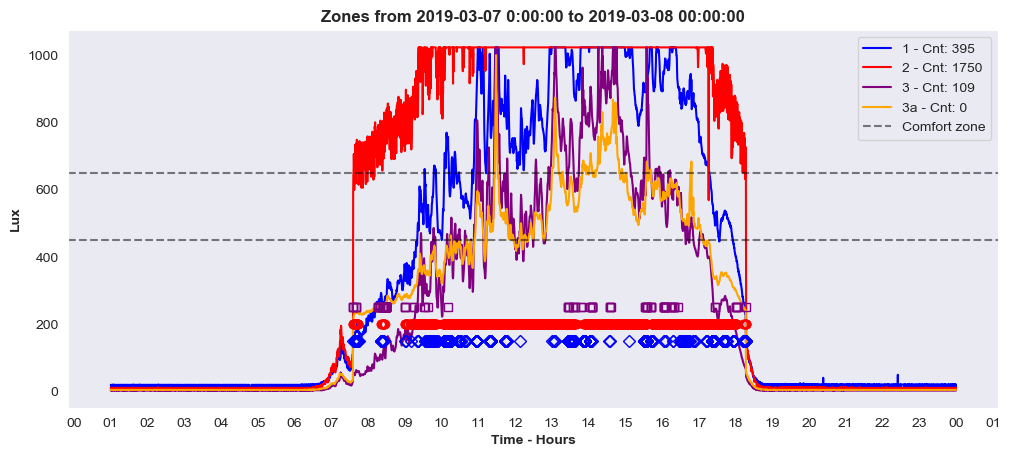

In [33]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
ax.plot(z1[mask_z1].index, z1[mask_z1].iloc[:,3], linestyle='-', marker='', color='blue', label=f'1 - Cnt: {mov_z1[mask_mov_z1].iloc[:,3].count()}')
ax.plot(z2[mask_z2].index, z2[mask_z2].iloc[:,3], linestyle='-', marker='', color='red', label=f'2 - Cnt: {mov_z2[mask_mov_z2].iloc[:,3].count()}')
ax.plot(z3[mask_z3].index, z3[mask_z3].iloc[:,3], linestyle='-', marker='', color='purple', label=f'3 - Cnt: {mov_z3[mask_mov_z3].iloc[:,3].count()}')
ax.plot(z3a[mask_z3a].index, z3a[mask_z3a].iloc[:,3], linestyle='-', marker='', color='orange', label=f'3a - Cnt: {mov_z3a[mask_mov_z3a].iloc[:,3].count()}')

ax.plot(mov_z1[mask_mov_z1].index, mov_z1[mask_mov_z1].iloc[:,3], linestyle='', marker='D', mec='blue', mfc='none')
ax.plot(mov_z2[mask_mov_z2].index, mov_z2[mask_mov_z2].iloc[:,3], linestyle='', marker='o', mec='red', mfc='none')
ax.plot(mov_z3[mask_mov_z3].index, mov_z3[mask_mov_z3].iloc[:,3], linestyle='', marker='s', mec='purple', mfc='none')
ax.plot(mov_z3a[mask_mov_z3a].index, mov_z3a[mask_mov_z3a].iloc[:,3], linestyle='', marker='P', mec='orange', mfc='none')

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b - %d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(hours_md)
ax.xaxis.set_major_formatter(hours_format)

# Comfort Zone
ax.axhline(650, linestyle='--', color='black', alpha=0.5, label = 'Comfort zone')
ax.axhline(450, linestyle='--', color='black', alpha=0.5)

ax.set_xlabel("Time - Hours", fontweight='bold')
ax.set_ylabel("Lux", fontweight='bold')
plt.title(f'Zones from {date_start} to {date_end}', fontweight='bold')
plt.legend(loc='best')
plt.show()

### Single Week Visualized

In [34]:
date_start = '2019-03-04 0:00:00'
date_end = '2019-03-11 00:00:00'

mask_z1 = (z1.index > date_start) & (z1.index < date_end)
mask_z2 = (z2.index > date_start) & (z2.index < date_end)
mask_z3 = (z3.index > date_start) & (z3.index < date_end)
mask_z3a = (z3a.index > date_start) & (z3a.index < date_end)

mask_mov_z1 = (mov_z1.index > date_start) & (mov_z1.index < date_end)
mask_mov_z2 = (mov_z2.index > date_start) & (mov_z2.index < date_end)
mask_mov_z3 = (mov_z3.index > date_start) & (mov_z3.index < date_end)
mask_mov_z3a = (mov_z3a.index > date_start) & (mov_z3a.index < date_end)

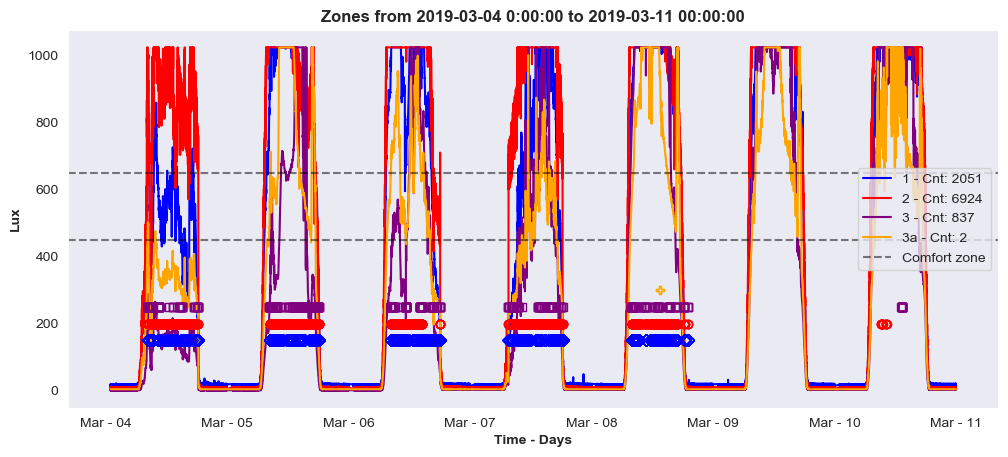

In [35]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
ax.plot(z1[mask_z1].index, z1[mask_z1].iloc[:,3], linestyle='-', marker='', color='blue', label=f'1 - Cnt: {mov_z1[mask_mov_z1].iloc[:,3].count()}')
ax.plot(z2[mask_z2].index, z2[mask_z2].iloc[:,3], linestyle='-', marker='', color='red', label=f'2 - Cnt: {mov_z2[mask_mov_z2].iloc[:,3].count()}')
ax.plot(z3[mask_z3].index, z3[mask_z3].iloc[:,3], linestyle='-', marker='', color='purple', label=f'3 - Cnt: {mov_z3[mask_mov_z3].iloc[:,3].count()}')
ax.plot(z3a[mask_z3a].index, z3a[mask_z3a].iloc[:,3], linestyle='-', marker='', color='orange', label=f'3a - Cnt: {mov_z3a[mask_mov_z3a].iloc[:,3].count()}')

ax.plot(mov_z1[mask_mov_z1].index, mov_z1[mask_mov_z1].iloc[:,3], linestyle='', marker='D', mec='blue', mfc='none')
ax.plot(mov_z2[mask_mov_z2].index, mov_z2[mask_mov_z2].iloc[:,3], linestyle='', marker='o', mec='red', mfc='none')
ax.plot(mov_z3[mask_mov_z3].index, mov_z3[mask_mov_z3].iloc[:,3], linestyle='', marker='s', mec='purple', mfc='none')
ax.plot(mov_z3a[mask_mov_z3a].index, mov_z3a[mask_mov_z3a].iloc[:,3], linestyle='', marker='P', mec='orange', mfc='none')

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b - %d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)

# Comfort Zone
ax.axhline(650, linestyle='--', color='black', alpha=0.5, label = 'Comfort zone')
ax.axhline(450, linestyle='--', color='black', alpha=0.5)

ax.set_xlabel("Time - Days", fontweight='bold')
ax.set_ylabel("Lux", fontweight='bold')
plt.title(f'Zones from {date_start} to {date_end}', fontweight='bold')
plt.legend(loc='best')
plt.show()

### Exploring time spans

In [36]:
mov_z1

,zone,sensor,id,n_passages
timestamp,,,,
2019-03-01 09:45:33,1,PIR,1,150
2019-03-01 09:45:37,1,PIR,1,150
2019-03-01 09:45:46,1,PIR,1,150
2019-03-01 09:46:49,1,PIR,1,150
2019-03-01 09:46:53,1,PIR,1,150
...,...,...,...,...
2019-03-25 18:12:23,1,PIR,1,150
2019-03-25 18:12:46,1,PIR,1,150
2019-03-25 18:12:50,1,PIR,1,150


In [37]:
for data in enumerate([z1, mov_z1, z2, mov_z2, z3, mov_z3, z3a, mov_z3a]):
    sorted_date = np.array(np.sort(data[1].index),dtype=np.datetime64)
    timedelta = sorted_date[-1] - sorted_date[0]
    
    print(f"Zone: {data[1].zone.unique()}\nSensor: {data[1].sensor.unique()}\nID: {data[1].id.unique()}\n")
    print(f"First date included: {np.datetime_as_string(sorted_date[0], unit='D')}")
    print(f"Last date included: {np.datetime_as_string(sorted_date[-1], unit='D')}")
    print(f"Time interval considered for Last Update: {timedelta.astype('timedelta64[D]').item().days} days.\n\n")

plt.show()


Zone: [1]
Sensor: ['LDR']
ID: [1]

First date included: 2019-02-25
Last date included: 2019-03-22
Time interval considered for Last Update: 25 days.


Zone: [1]
Sensor: ['PIR']
ID: [1]

First date included: 2019-03-01
Last date included: 2019-03-25
Time interval considered for Last Update: 24 days.


Zone: [2]
Sensor: ['LDR']
ID: [2 1]

First date included: 2019-02-25
Last date included: 2019-03-14
Time interval considered for Last Update: 17 days.


Zone: [2]
Sensor: ['PIR']
ID: [2]

First date included: 2019-03-01
Last date included: 2019-03-14
Time interval considered for Last Update: 13 days.


Zone: [3]
Sensor: ['LDR']
ID: [3]

First date included: 2019-02-25
Last date included: 2019-03-25
Time interval considered for Last Update: 28 days.


Zone: [3]
Sensor: ['PIR']
ID: [3]

First date included: 2019-03-01
Last date included: 2019-03-25
Time interval considered for Last Update: 24 days.


Zone: [3]
Sensor: ['LDR']
ID: [4]

First date included: 2019-02-25
Last date included: 2019-

In [38]:
z1

,zone,sensor,id,value
timestamp,,,,
2019-02-25 01:00:00,1,LDR,1,12
2019-02-25 01:00:20,1,LDR,1,19
2019-02-25 01:00:40,1,LDR,1,19
2019-02-25 01:01:00,1,LDR,1,18
2019-02-25 01:01:20,1,LDR,1,18
...,...,...,...,...
2019-03-22 14:11:29,1,LDR,1,1001
2019-03-22 14:11:49,1,LDR,1,1001
2019-03-22 14:12:09,1,LDR,1,999


In [39]:
# Extract 'date' and 'hour'

for data in [z1, z2, z3, z3a, mov_z1, mov_z2, mov_z3, mov_z3a]:

    data.reset_index(inplace = True)
    
    data['date'] = data.timestamp.dt.date
    data['hour'] = data.timestamp.dt.hour

# Re-labeling

z1['label'] = 1
z2['label'] = 2
z3['label'] = 3
z3a['label'] = 4
mov_z1['label'] = 1
mov_z2['label'] = 2
mov_z3['label'] = 3
mov_z3a['label'] = 4

#### Extracting minimum and maximum hour in which movements are detected, for each day and zone

In [40]:
mov_ranges = [pd.DataFrame() for _ in range(4)]

for data in enumerate([mov_z1,mov_z2,mov_z3, mov_z3a]):
    i = data[0]
    mov_z = data[1]
    
    # Groupby DAY & HOUR DataFrame
    gb_dh = mov_z\
                .groupby(['date','hour'], as_index=False)['n_passages']\
                .sum()\
                .sort_values(['date','hour'])
    
    # Extract first and ending hour for each day
    gb_mm = gb_dh\
                .groupby(['date'],as_index=False)['hour']\
                .min()\
                .rename(columns={'hour':'hour_min'})\
                .merge(gb_dh\
                            .groupby(['date'],as_index=False)['hour']\
                            .max()\
                            .rename(columns={'hour':'hour_max'}),
                       on='date'
                      )
    
    mov_ranges[i] = gb_mm


In [41]:
# Snapshot of starting and ending hour for each day in each zone
[print("\nLABEL: ", i+1, "\n", df.head()) for i,df in enumerate(mov_ranges)]


LABEL:  1 
          date  hour_min  hour_max
0  2019-03-01         9        15
1  2019-03-03         9         9
2  2019-03-04         8        18
3  2019-03-05         8        18
4  2019-03-06         8        18

LABEL:  2 
          date  hour_min  hour_max
0  2019-03-01         9        15
1  2019-03-03         9         9
2  2019-03-04         8        18
3  2019-03-05         8        18
4  2019-03-06         8        18

LABEL:  3 
          date  hour_min  hour_max
0  2019-03-01         9        15
1  2019-03-03         9         9
2  2019-03-04         8        18
3  2019-03-05         8        18
4  2019-03-06         8        18

LABEL:  4 
          date  hour_min  hour_max
0  2019-03-08        13        13
1  2019-03-11         7         7
2  2019-03-14         9        11
3  2019-03-15         8         8
4  2019-03-20        17        17


[None, None, None, None]

## Average Past Distribution Lux extraction
#### Model: 
##### <i> value(t) = outdoor_ligh(t) * (1 - curtains_level) * (1 - 0.4*cloud_level(t)) + indoor_light(t) <i/>

### Method 1
- We make the assumption that curtains influence is not presence on past sensor data -> <i> curtains_level = 0 <i/>.
- Past wather data are extracted through an API.
- Indoor light is extracted by considering that they were on from the first to the last movement in the lab.

#### Extraction of *indoor_light(t)*
- For each zone and day, create a time-series with values equal to the intensity of neon's light (i.e. 450) for the hours between minimum and maximum hour (corresponding to the first and last detected movement in a certain zone of the lab).

In [42]:
# Create an empty template of 24 elements
tmp = pd.DataFrame(np.zeros(24), index=[str(x) for x in range(24)], dtype=int).reset_index().rename(columns={'index':'hour',0:'flag'})
tmp.hour = tmp.hour.astype(int)

# Initialize a list of 4 empty DataFrames (one for each zone)
mov_flags = [pd.DataFrame() for _ in range(4)]

for data in enumerate(mov_ranges):
    
    i = data[0]
    mov_r = data[1]
    
    # Initialize DataFrame for i^th zone
    df = pd.DataFrame(columns=['date','hour','flag'])
    
    # Create a series of 24 elements with values equal to 450 for hours between minimum and maximum hour, for each day
    for d in mov_r.date:
        tmp2 = tmp.copy()
        
        tmp2['date'] = d
        
        # Find the elements between minumum and maximum hour
        mask = (tmp2.hour.values >= mov_r.hour_min[mov_r.date==d].values) \
                & (tmp2.hour.values <= mov_r.hour_max[mov_r.date==d].values)
        tmp2.loc[mask,'flag'] = 450
        
        # Order columns
        tmp2 = tmp2[['date','hour','flag']]
        
        # Update i^th zone DataFrame
        df = pd.concat([df, tmp2], axis=0)
    
    mov_flags[i] = df.reset_index(drop = True)
    

In [43]:
# Snapshot of the generated time-series, for a certain day in each zone, from 6 a.m. to 8 p.m.
n_day = 0
bias = 24*n_day
[print("\nLABEL: ", i+1, "\n", df[6+bias:21+bias]) for i,df in enumerate(mov_flags)]


LABEL:  1 
           date hour flag
6   2019-03-01    6    0
7   2019-03-01    7    0
8   2019-03-01    8    0
9   2019-03-01    9  450
10  2019-03-01   10  450
11  2019-03-01   11  450
12  2019-03-01   12  450
13  2019-03-01   13  450
14  2019-03-01   14  450
15  2019-03-01   15  450
16  2019-03-01   16    0
17  2019-03-01   17    0
18  2019-03-01   18    0
19  2019-03-01   19    0
20  2019-03-01   20    0

LABEL:  2 
           date hour flag
6   2019-03-01    6    0
7   2019-03-01    7    0
8   2019-03-01    8    0
9   2019-03-01    9  450
10  2019-03-01   10  450
11  2019-03-01   11  450
12  2019-03-01   12  450
13  2019-03-01   13  450
14  2019-03-01   14  450
15  2019-03-01   15  450
16  2019-03-01   16    0
17  2019-03-01   17    0
18  2019-03-01   18    0
19  2019-03-01   19    0
20  2019-03-01   20    0

LABEL:  3 
           date hour flag
6   2019-03-01    6    0
7   2019-03-01    7    0
8   2019-03-01    8    0
9   2019-03-01    9  450
10  2019-03-01   10  450
11  2019-03

[None, None, None, None]

In [44]:
# GET DATETIME VARIABLE (combine DATE and TIME)
for data in enumerate(mov_flags):
    dt = []
    i = data[0]
    mov_flag = data[1]
    
    for i in range(mov_flag.shape[0]):

        d = mov_flag['date'][i]
        t = time(mov_flag['hour'][i], 0)
        dt.append(datetime.combine(d, t))

    mov_flag['timestamp'] = dt

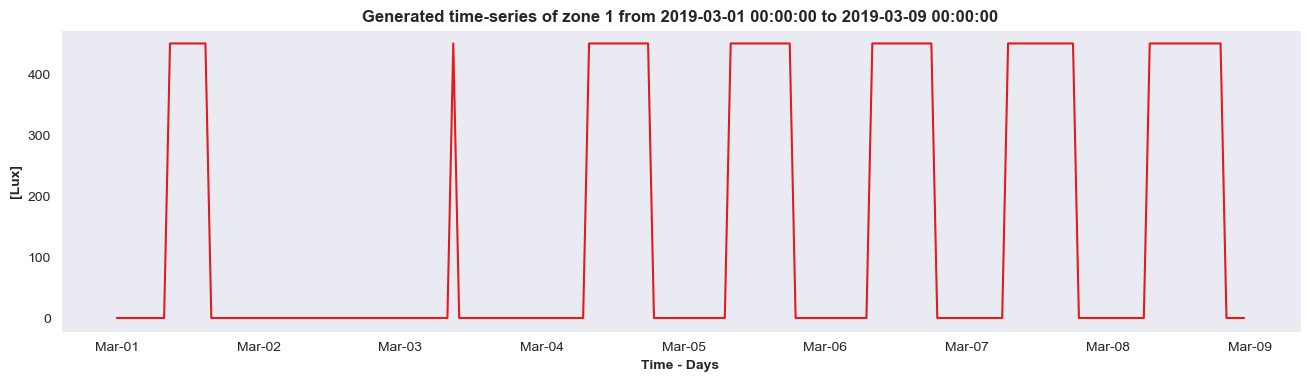

In [45]:
# VISUALIZE - generated time-series for zone 1

# Set time interval
date_start = '2019-03-01 00:00:00'
date_end = '2019-03-09 00:00:00'
# Choose zone
i = 0 # zone 1

data = mov_flags[i]
mask = (data.timestamp >= date_start) & (data.timestamp <= date_end)

fig, ax = plt.subplots(figsize=(16, 4), dpi=100)

ax.plot(data.timestamp[mask],data.flag[mask])

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b-%d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)

ax.set_xlabel("Time - Days", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Generated time-series of zone {i+1} from {date_start} to {date_end}', fontweight='bold')

plt.show()

- Since different lighting schedules can't be made among lab zones, each generated time-series can't represent on its own the state of *indoor_light* in each lab zone.
- Consequently, in order to have the *indoor_light* time-series for all the days, for each day, a union operation among all lab zones generated time-series should be made.

In [46]:
# Unique DataFrame representing the "indoor_light" time-series for the whole lab
mov_flag = pd.concat([mov_flags[0],
                      mov_flags[1],
                      mov_flags[2],
                      mov_flags[3]
                     ], axis=0)\
                .drop_duplicates()\
                .sort_values('timestamp')\
                .groupby('timestamp', as_index = False).max()\
                .reset_index(drop = True)

In [47]:
# Snapshot of "indoor_light" time-series, for a certain day, from 6 a.m. to 8 p.m.
n_day = 0
bias = 24*n_day
print(mov_flag[6+bias:21+bias])

             timestamp        date  hour  flag
6  2019-03-01 06:00:00  2019-03-01     6     0
7  2019-03-01 07:00:00  2019-03-01     7     0
8  2019-03-01 08:00:00  2019-03-01     8     0
9  2019-03-01 09:00:00  2019-03-01     9   450
10 2019-03-01 10:00:00  2019-03-01    10   450
11 2019-03-01 11:00:00  2019-03-01    11   450
12 2019-03-01 12:00:00  2019-03-01    12   450
13 2019-03-01 13:00:00  2019-03-01    13   450
14 2019-03-01 14:00:00  2019-03-01    14   450
15 2019-03-01 15:00:00  2019-03-01    15   450
16 2019-03-01 16:00:00  2019-03-01    16     0
17 2019-03-01 17:00:00  2019-03-01    17     0
18 2019-03-01 18:00:00  2019-03-01    18     0
19 2019-03-01 19:00:00  2019-03-01    19     0
20 2019-03-01 20:00:00  2019-03-01    20     0


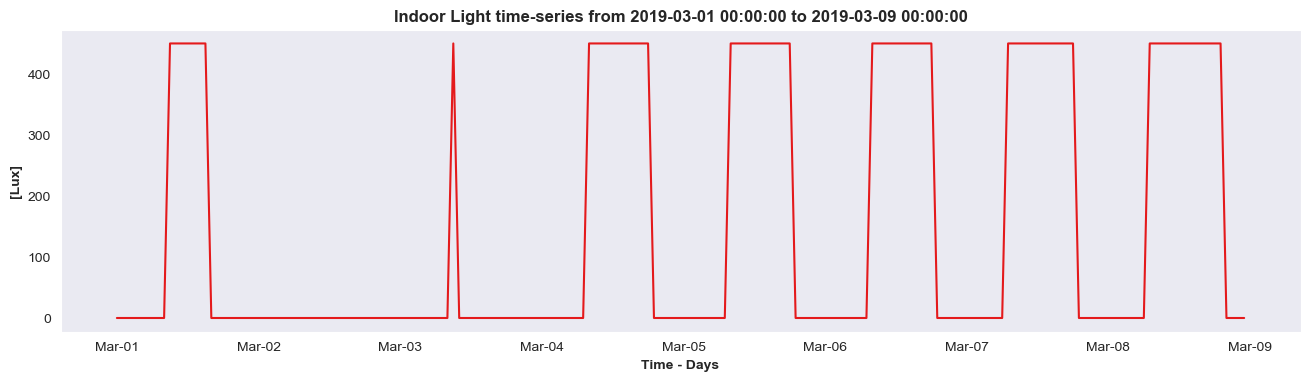

In [48]:
# VISUALIZE - 'indoor_light' time-series

# Set time interval
date_start = '2019-03-01 00:00:00'
date_end = '2019-03-09 00:00:00'

data = mov_flag
mask = (data.timestamp >= date_start) & (data.timestamp <= date_end)

fig, ax = plt.subplots(figsize=(16, 4), dpi=100)

ax.plot(data.timestamp[mask],data.flag[mask])

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b-%d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)

ax.set_xlabel("Time - Days", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Indoor Light time-series from {date_start} to {date_end}', fontweight='bold')

plt.show()

In [49]:
mov_flag

,timestamp,date,hour,flag
0,2019-03-01 00:00:00,2019-03-01,0,0
1,2019-03-01 01:00:00,2019-03-01,1,0
2,2019-03-01 02:00:00,2019-03-01,2,0
3,2019-03-01 03:00:00,2019-03-01,3,0
4,2019-03-01 04:00:00,2019-03-01,4,0
...,...,...,...,...
475,2019-03-25 19:00:00,2019-03-25,19,0
476,2019-03-25 20:00:00,2019-03-25,20,0
477,2019-03-25 21:00:00,2019-03-25,21,0
478,2019-03-25 22:00:00,2019-03-25,22,0


In [50]:
indoor_light = mov_flag.copy()

### Data Preparation

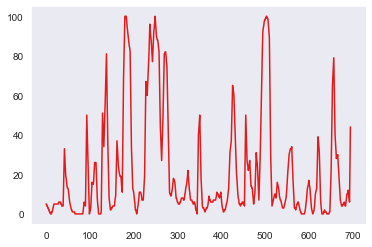

In [51]:
weather.cloudcover.plot()
plt.show()

In [52]:
# Weather time-series
weather.rename(columns={'date':'timestamp'}, inplace=True)
weather.timestamp = pd.to_datetime(weather.timestamp)
weather.index = weather.timestamp
weather = weather\
                .resample('1min')\
                .agg({'cloudcover':'mean'})\
                .fillna(method='ffill')\
                .reset_index()

# LDR time-series
z_res = [pd.DataFrame() for _ in range(4)]
for data in enumerate([z1,z2,z3,z3a]):
    i = data[0]
    z = data[1].copy()
    
    z.timestamp = pd.to_datetime(z.timestamp)
    z.set_index(z.timestamp, inplace=True)    
    z_res[i] = z\
                .resample('1min')\
                .agg({'value':'mean'})\
                .reset_index()

# indoor_light time-series
indoor_light.timestamp = pd.to_datetime(indoor_light.timestamp)
indoor_light.index = indoor_light.timestamp
indoor_light = indoor_light\
                        .resample('1min')\
                        .agg({'flag':'mean'})\
                        .fillna(method = 'ffill')\
                        .reset_index()

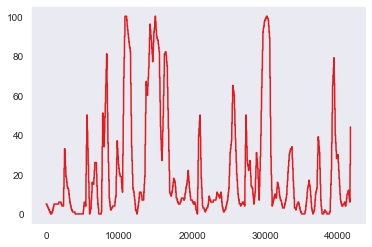

In [53]:
weather['cloudcover'].plot()
plt.show()

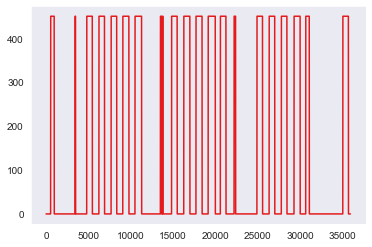

In [54]:
indoor_light['flag'].plot()
plt.show()

In [55]:
# MERGING DATAFRAMES
z_merged = [pd.DataFrame() for _ in range(4)]
for data in enumerate(z_res):
    i = data[0]
    z = data[1].copy()
    
    z_merged[i] = z\
                    .merge(weather,  on='timestamp')\
                    .merge(indoor_light, on='timestamp')\
                    .fillna(method='backfill')\
                    .sort_values('timestamp')
    
    # Compute "outdoor_light" time-series
    z_merged[i]['outdoor_light'] = (z_merged[i]['value'] - z_merged[i]['flag'])/(1 - 0.4 * z_merged[i]['cloudcover']/100) # cloudcover is in %
    
    z_merged[i]['date'] = z_merged[i].timestamp.dt.date
    z_merged[i]['hour'] = z_merged[i].timestamp.dt.hour
    z_merged[i] = z_merged[i][['timestamp','date','hour','outdoor_light','value','flag','cloudcover']]

In [56]:
# Snapshot, for a certain day, from 6 a.m. to 8 p.m.
n_day = 0
bias = 24*n_day
[print(df[6+bias:21+bias]) for df in z_merged]

             timestamp        date  hour  outdoor_light  value  flag  \
6  2019-03-01 00:06:00  2019-03-01     0      21.111111   19.0   0.0   
7  2019-03-01 00:07:00  2019-03-01     0      21.111111   19.0   0.0   
8  2019-03-01 00:08:00  2019-03-01     0      21.111111   19.0   0.0   
9  2019-03-01 00:09:00  2019-03-01     0      21.111111   19.0   0.0   
10 2019-03-01 00:10:00  2019-03-01     0      21.111111   19.0   0.0   
11 2019-03-01 00:11:00  2019-03-01     0      21.111111   19.0   0.0   
12 2019-03-01 00:12:00  2019-03-01     0      21.111111   19.0   0.0   
13 2019-03-01 00:13:00  2019-03-01     0      21.111111   19.0   0.0   
14 2019-03-01 00:14:00  2019-03-01     0      21.111111   19.0   0.0   
15 2019-03-01 00:15:00  2019-03-01     0      21.111111   19.0   0.0   
16 2019-03-01 00:16:00  2019-03-01     0      21.111111   19.0   0.0   
17 2019-03-01 00:17:00  2019-03-01     0      21.111111   19.0   0.0   
18 2019-03-01 00:18:00  2019-03-01     0      21.111111   19.0  

[None, None, None, None]

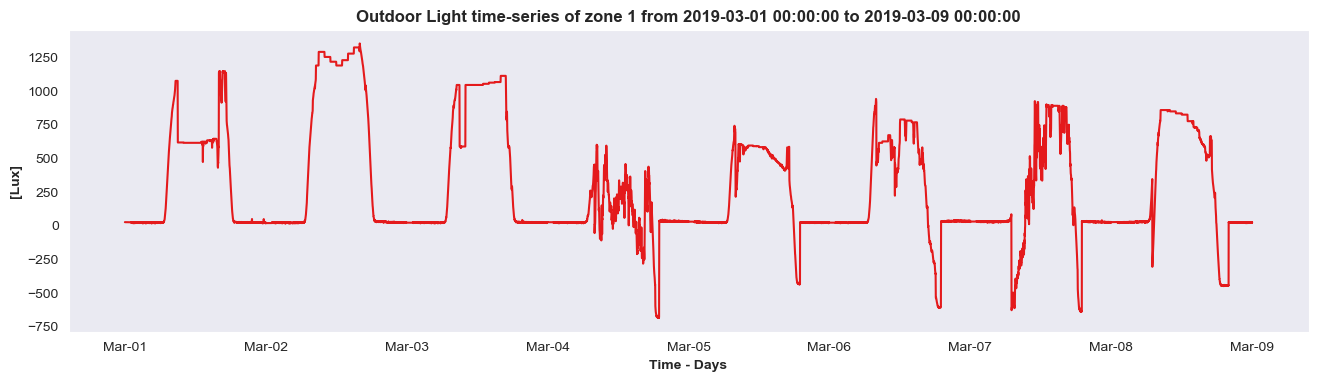

In [57]:
# VISUALIZE - 'outdoor_light' time-series

# Set time interval
date_start = '2019-03-01 00:00:00'
date_end = '2019-03-09 00:00:00'
i = 0
data = z_merged[i]
mask = (data.timestamp >= date_start) & (data.timestamp <= date_end)

fig, ax = plt.subplots(figsize=(16, 4), dpi=100)

ax.plot(data.timestamp[mask],data.outdoor_light[mask])

# Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b-%d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)

ax.set_xlabel("Time - Days", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Outdoor Light time-series of zone {i+1} from {date_start} to {date_end}', fontweight='bold')

plt.show()

There seems to be something wrong.

In [58]:
# Find values of sensor data lower than the value of the neon's light
data.query('flag>value')

,timestamp,date,hour,outdoor_light,value,flag,cloudcover
4800,2019-03-04 08:00:00,2019-03-04,8,-60.000000,402.000000,450.0,50.0
4801,2019-03-04 08:01:00,2019-03-04,8,-28.750000,427.000000,450.0,50.0
4802,2019-03-04 08:02:00,2019-03-04,8,-10.000000,442.000000,450.0,50.0
4850,2019-03-04 08:50:00,2019-03-04,8,-24.583333,430.333333,450.0,50.0
4851,2019-03-04 08:51:00,2019-03-04,8,-44.583333,414.333333,450.0,50.0
...,...,...,...,...,...,...,...
29995,2019-03-21 19:55:00,2019-03-21,19,-443.181818,21.000000,450.0,8.0
29996,2019-03-21 19:56:00,2019-03-21,19,-443.870523,20.333333,450.0,8.0
29997,2019-03-21 19:57:00,2019-03-21,19,-443.526171,20.666667,450.0,8.0
29998,2019-03-21 19:58:00,2019-03-21,19,-443.870523,20.333333,450.0,8.0


In [59]:
# Create a TEMPLATE of 'outdoor_light' for each sensor
z_tmps = [pd.DataFrame() for _ in range(4)]
for data in enumerate(z_merged):
    i = data[0]
    z = data[1].copy()
    
    z_tmps[i] = z\
                    .groupby('hour', as_index=False)['outdoor_light']\
                    .mean()


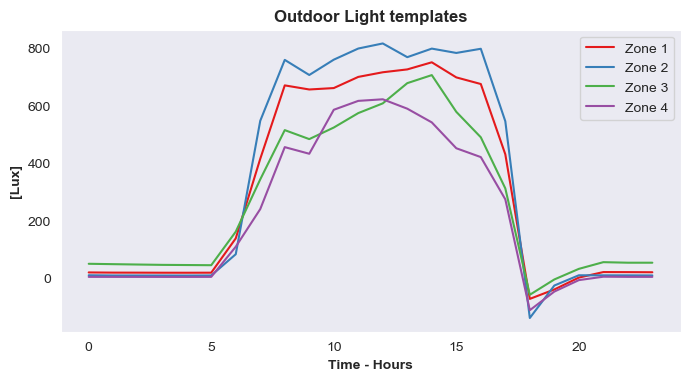

In [60]:
# VISUALIZE - one template for each sensor
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

for i in range(len(z_tmps)):

    data = z_tmps[i]

    ax.plot(data.outdoor_light, label='Zone '+str(i+1))

ax.set_xlabel("Time - Hours", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Outdoor Light templates', fontweight='bold')

plt.legend()
plt.show()



In [61]:
z_tmp = pd.concat([z_tmps[0],
                   z_tmps[1],
                   z_tmps[2],
                   z_tmps[3]
                  ], axis=0)\
            .reset_index()\
            .drop(['index'], axis=1)\
            .groupby('hour', as_index=False)\
            .mean()

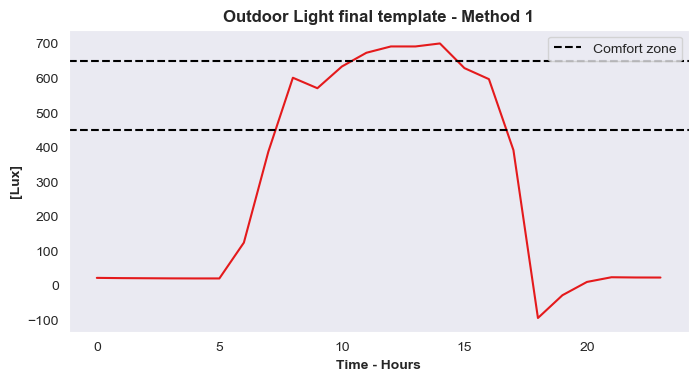

In [62]:
# VISUALIZE - final TEMPLATE
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = z_tmp

ax.plot(data.outdoor_light)
ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')

ax.set_xlabel("Time - Hours", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Outdoor Light final template - Method 1', fontweight='bold')

plt.legend(loc='best')

plt.savefig('Final template - Method 1.png')
plt.show()


### Considerations about Method 1:
The template is clearly wrong:
- between 8 a.m. and 9 a.m., there's an inversion of light's trend, which cannot be true.
- between 6 p.m. and 7 p.m., there's a negative peak, which indicates that the extracted *indoor_light* is still at 450, while sensors' data record values lower than 450.

### Method 2
- Extract *outdoor_light* template from weekend days past sensor data, which should not be influenced by any *indoor_light*.
- Extract *outdoor_light* template from weekdays past sensor data, which are supposedly influenced by *indoor_light*, without removing *indoor_light*'s effect.
- We still filter out *weather*'s effect and assume *curtains_level* = 0.
- Compare the 2 templates.
- Use movement data in order to get the time interval of interest for considering the *Comfort zone*.

In [63]:
# Weekend days
wkend = z_res[0].timestamp[(z_res[0].timestamp.dt.dayofweek==5) | (z_res[0].timestamp.dt.dayofweek==6)].dt.date.unique()
print(f"Weekend: {len(wkend)} days\n", wkend)
# Weekdays
wkd = z_res[0].timestamp[(z_res[0].timestamp.dt.dayofweek!=5) & (z_res[0].timestamp.dt.dayofweek!=6)].dt.date.unique()
print(f"\nWeekdays: {len(wkd)} days\n", wkd)

Weekend: 6 days
 [datetime.date(2019, 3, 2) datetime.date(2019, 3, 3)
 datetime.date(2019, 3, 9) datetime.date(2019, 3, 10)
 datetime.date(2019, 3, 16) datetime.date(2019, 3, 17)]

Weekdays: 20 days
 [datetime.date(2019, 2, 25) datetime.date(2019, 2, 26)
 datetime.date(2019, 2, 27) datetime.date(2019, 2, 28)
 datetime.date(2019, 3, 1) datetime.date(2019, 3, 4)
 datetime.date(2019, 3, 5) datetime.date(2019, 3, 6)
 datetime.date(2019, 3, 7) datetime.date(2019, 3, 8)
 datetime.date(2019, 3, 11) datetime.date(2019, 3, 12)
 datetime.date(2019, 3, 13) datetime.date(2019, 3, 14)
 datetime.date(2019, 3, 15) datetime.date(2019, 3, 18)
 datetime.date(2019, 3, 19) datetime.date(2019, 3, 20)
 datetime.date(2019, 3, 21) datetime.date(2019, 3, 22)]


In [64]:
# MERGING DATAFRAMES
z_merged = [pd.DataFrame() for _ in range(4)]
for data in enumerate(z_res):
    i = data[0]
    z = data[1].copy()
    
    z_merged[i] = z\
                    .merge(weather,  on='timestamp')\
                    .fillna(method='backfill')\
                    .sort_values('timestamp')
    
    # Compute "outdoor_light" time-series
    z_merged[i]['outdoor_light'] = z_merged[i]['value']/(1 - 0.4 * z_merged[i]['cloudcover']/100) # cloudcover is in %
    
    # Additional useful columns
    z_merged[i]['date'] = z_merged[i].timestamp.dt.date
    z_merged[i]['hour'] = z_merged[i].timestamp.dt.hour
    z_merged[i]['minute'] = z_merged[i].timestamp.dt.minute
    z_merged[i]['wkend'] = (z_merged[i].timestamp.dt.dayofweek==5)|(z_merged[i].timestamp.dt.dayofweek==6)
        
    # Reordering columns
    z_merged[i] = z_merged[i][['timestamp','date','hour','minute','wkend','outdoor_light','value','cloudcover']]

In [65]:
# Preview
n_day = 0
bias = 24*n_day*60
[print(df[6*60+bias:21*60+bias]) for df in z_merged]

               timestamp        date  hour  minute  wkend  outdoor_light  \
360  2019-02-25 07:00:00  2019-02-25     7       0  False      71.572581   
361  2019-02-25 07:01:00  2019-02-25     7       1  False      80.309140   
362  2019-02-25 07:02:00  2019-02-25     7       2  False      84.005376   
363  2019-02-25 07:03:00  2019-02-25     7       3  False      97.110215   
364  2019-02-25 07:04:00  2019-02-25     7       4  False     105.510753   
...                  ...         ...   ...     ...    ...            ...   
1255 2019-02-25 21:55:00  2019-02-25    21      55  False      20.408163   
1256 2019-02-25 21:56:00  2019-02-25    21      56  False      20.408163   
1257 2019-02-25 21:57:00  2019-02-25    21      57  False      20.408163   
1258 2019-02-25 21:58:00  2019-02-25    21      58  False      18.367347   
1259 2019-02-25 21:59:00  2019-02-25    21      59  False      20.408163   

           value  cloudcover  
360    71.000000         2.0  
361    79.666667         

[None, None, None, None]

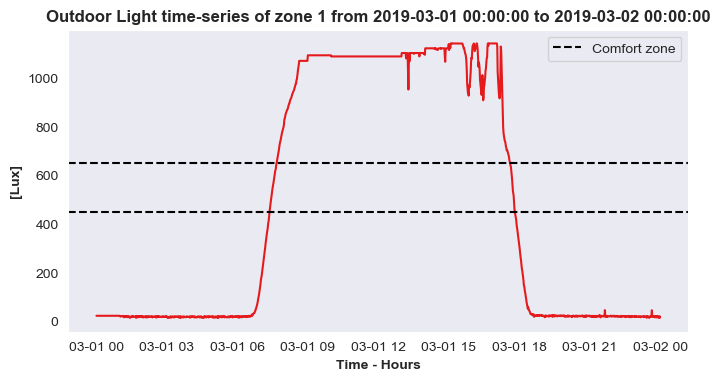

In [66]:
# VISUALIZE - 'outdoor_light' time-series, for a certain time interval and a certain lab zone
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

date_start = '2019-03-01 00:00:00'
date_end = '2019-03-02 00:00:00'
i = 0
data = z_merged[i]
mask = (data.timestamp >= date_start) & (data.timestamp <= date_end)

ax.plot(data.timestamp[mask], data.outdoor_light[mask])
ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')

ax.set_xlabel("Time - Hours", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')
plt.title(f'Outdoor Light time-series of zone {i+1} from {date_start} to {date_end}', fontweight='bold')

plt.legend(loc='best')

plt.show()

In [67]:
# Create a TEMPLATE of 'outdoor_light' for each sensor
z_tmps = [pd.DataFrame() for _ in range(4)]
for data in enumerate(z_merged):
    i = data[0]
    z = data[1].copy()
    
    z_tmps[i] = z\
                    .groupby(['hour','minute','wkend'], as_index=False)['outdoor_light']\
                    .mean()


In [68]:
z_tmps[0]

,hour,minute,wkend,outdoor_light
0,0,0,False,19.821446
1,0,0,True,19.429424
2,0,1,False,19.821446
3,0,1,True,19.429424
4,0,2,False,19.821446
...,...,...,...,...
2875,23,57,True,19.367901
2876,23,58,False,20.200660
2877,23,58,True,20.044048
2878,23,59,False,20.304673


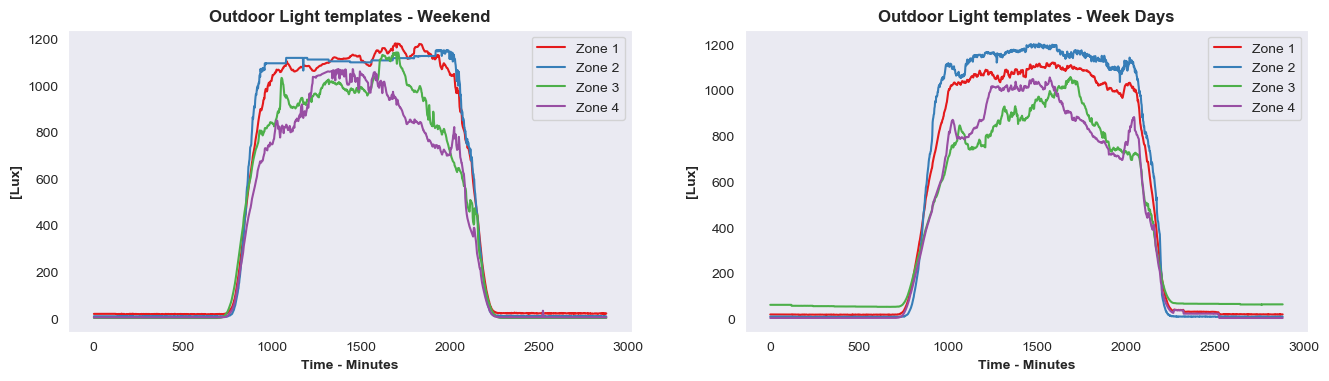

In [69]:
# VISUALIZE - one template for each zone
fig, ax = plt.subplots(1,2, figsize=(16, 4), dpi=100)

for i in range(len(z_tmps)):

    data = z_tmps[i]
    
    msk = data.wkend
    ax[0].plot(data.outdoor_light[msk], label='Zone '+str(i+1))
    ax[0].set_title(f'Outdoor Light templates - Weekend', fontweight='bold')

    ax[0].set_xlabel("Time - Minutes", fontweight='bold')
    ax[0].set_ylabel("[Lux]", fontweight='bold')

    ax[0].legend()
    
    ax[1].plot(data.outdoor_light[~msk], label='Zone '+str(i+1))
    ax[1].set_title(f'Outdoor Light templates - Week Days', fontweight='bold')
    
    ax[1].set_xlabel("Time - Minutes", fontweight='bold')
    ax[1].set_ylabel("[Lux]", fontweight='bold')

    ax[1].legend()


plt.show()


In [70]:
z_tmp = pd.concat([z_tmps[0],
                   z_tmps[1],
                   z_tmps[2],
                   z_tmps[3]
                  ], axis=0)\
            .reset_index()\
            .drop(['index'], axis=1)\
            .groupby(['hour','minute','wkend'], as_index=False)\
            .mean()

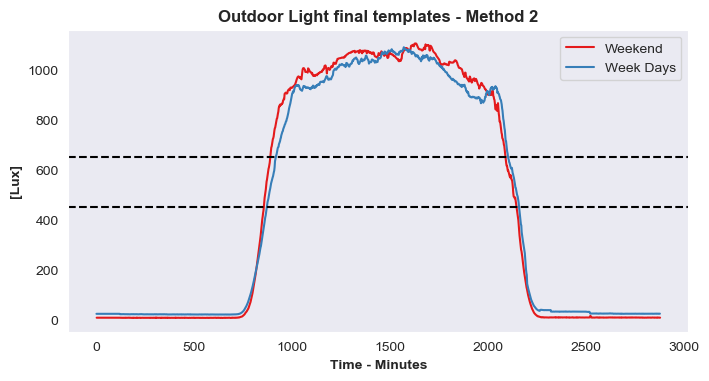

In [71]:
# VISUALIZE - final TEMPLATES

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = z_tmp
msk = data.wkend

ax.plot(data.outdoor_light[msk], label='Weekend')
ax.plot(data.outdoor_light[~msk], label='Week Days')

ax.set_title('Outdoor Light final templates - Method 2', fontweight = 'bold')
ax.legend()

ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')

ax.set_xlabel("Time - Minutes", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')


plt.savefig('Templates - Method 2.png')
plt.show()


### Consideration about Method 2:
- The 2 extracted templates seem not to significantly differ from each other, at least from graphical point of view.
- This could let us consider all past sensor data as not influenced by *indoor_light* of the laboratory, and, so as a unique source for generating the template.
- The winning model would then be:  <b> *value(t)* = *outdoor_light(t)* * (1 - *cloud_cover(t)* * 0.4) <b/>

In [72]:
# Create a unique template
z_tmp_final = z_tmp\
                    .groupby(['hour','minute'], as_index=False)\
                    .mean()

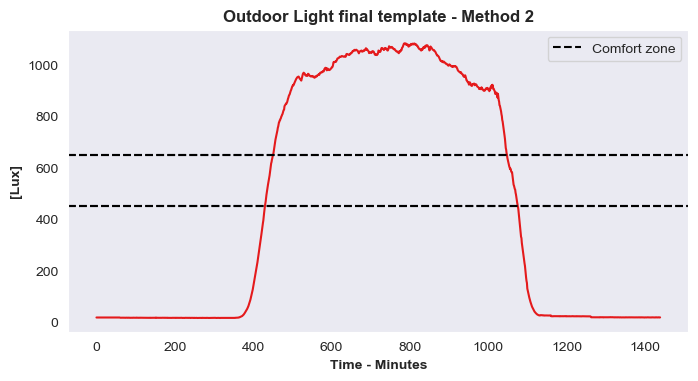

In [73]:
# VISUALIZE - final TEMPLATE

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = z_tmp_final

ax.plot(data.outdoor_light)

ax.set_title('Final template')

ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')

ax.set_title('Outdoor Light final template - Method 2', fontweight = 'bold')
ax.legend()

ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')

ax.set_xlabel("Time - Minutes", fontweight='bold')
ax.set_ylabel("[Lux]", fontweight='bold')


plt.savefig('Final Template - Method 2.png')

plt.show()

In [74]:
print(z_tmp_final.shape)
z_tmp_final.head()

(1440, 4)


,hour,minute,wkend,outdoor_light
0,0,0,0.5,16.477478
1,0,1,0.5,16.477478
2,0,2,0.5,16.477478
3,0,3,0.5,16.477478
4,0,4,0.5,16.477478


Extract the time interval of interest for considering the Comfort zone: minimum and maximum hour in which movements have been detected.

In [75]:
# Unique DataFrame representing the "neon time-series" for the whole lab
mov_range = pd.concat([mov_ranges[0],
                      mov_ranges[1],
                      mov_ranges[2],
                      mov_ranges[3]
                     ], axis=0)\
                .drop_duplicates()\
                .sort_values('date')\
                .reset_index()\
                .drop(['index'], axis=1)\
                .agg({'hour_min':'min', 'hour_max':'max'})

mov_range.head()

hour_min     7
hour_max    20
dtype: int64

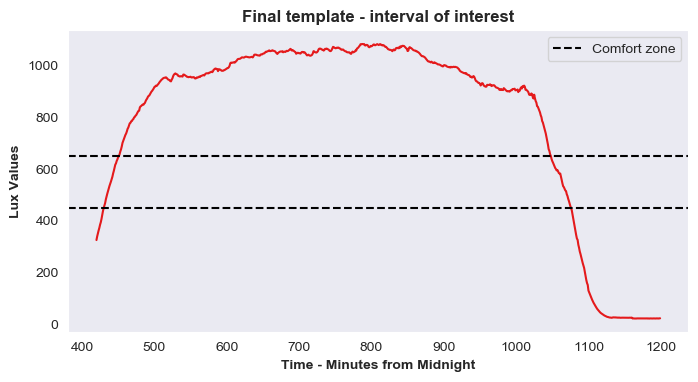

In [76]:
# VISUALIZE - final TEMPLATE with mov_range

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = z_tmp_final[mov_range.hour_min*60:mov_range.hour_max*60]

ax.plot(data.outdoor_light)

ax.set_title('Final template - interval of interest', fontweight = 'bold')

ax.axhline(450, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650, linestyle = '--', color='black')
ax.set_xlabel("Time - Minutes from Midnight", fontweight='bold')
ax.set_ylabel("Lux Values", fontweight='bold')

plt.legend()

plt.savefig('Final template (interval of interest) - Method 2.png')
plt.show()

### Costs optimization
Find the best option in order to minimize the costs.

Create a parameters grid generator function.

In [77]:
import itertools as it

c = [0, 0.3, 0.6]
neon = [0, 1, 'False']
led = [0, 0.5, 1, 'False']

settings = {'Curtains': c,
            'LED': led,
            'Neon': neon}

def possible_gs_params(parameters):
    """
    Arguments:
        parameters (dictionary): dictionary with keys (str) the name of the params and values (list) lists of possible parameters.
    Returns:
        list of dictionaries (list)
    """
    d = parameters.copy()
    combinations = list(it.product(*(d[key] for key in d)))
    names = [*d.keys()]
    list_params = []
    for i in range(len(combinations)):
        params = dict(zip(names, combinations[i]))
        ### Conditions that consider only the options that make sense for our case
        if ((params['Neon'] != 'False') and (params['LED'] != 'False')) or ((params['Neon'] == 'False') and (params['LED'] == 'False')):
            continue
        list_params.append(params)
    return list_params

possible_params = possible_gs_params(settings)

In [78]:
possible_params

[{'Curtains': 0, 'LED': 0, 'Neon': 'False'},
 {'Curtains': 0, 'LED': 0.5, 'Neon': 'False'},
 {'Curtains': 0, 'LED': 1, 'Neon': 'False'},
 {'Curtains': 0, 'LED': 'False', 'Neon': 0},
 {'Curtains': 0, 'LED': 'False', 'Neon': 1},
 {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'},
 {'Curtains': 0.3, 'LED': 0.5, 'Neon': 'False'},
 {'Curtains': 0.3, 'LED': 1, 'Neon': 'False'},
 {'Curtains': 0.3, 'LED': 'False', 'Neon': 0},
 {'Curtains': 0.3, 'LED': 'False', 'Neon': 1},
 {'Curtains': 0.6, 'LED': 0, 'Neon': 'False'},
 {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'},
 {'Curtains': 0.6, 'LED': 1, 'Neon': 'False'},
 {'Curtains': 0.6, 'LED': 'False', 'Neon': 0},
 {'Curtains': 0.6, 'LED': 'False', 'Neon': 1}]

In [79]:
def hourly_neon_cost(electricity_cost = 0.3,
                    n_neon = 48,
                    single_neon_consumption = 30):
    """
    Args:
        electricity_cost (float): € / kWh
        n_neon_lights (int): 12 fixtures * 4 neon lights per fixture
        single_light_consumption (int): W
    Returns:
        float
    """
    return (electricity_cost * n_neon * single_neon_consumption) / 1000

Define the cost function

In [80]:
# Time interval of interest
hours = np.arange(mov_range.hour_min, mov_range.hour_max+1)

# Scenario 1: Neon + No Automation of Curtains + level of curtains [0, 0.3, 0.6] manually set
# Scenario 2: LED + No Automation of Curtains + level of curtains [0, 0.3, 0.6] manually set
# Scenario 3: Neon + Automation of Curtains [0, 0.3, 0.6] set hourly
# Scenario 4: LED + Automation of Curtains [0, 0.3, 0.6] set hourly

def cost_daily(lux_template, hours, 
               column = 'outdoor_light', 
               date = None,
               curtains_level = 'Auto',
               neon = True,
               investment_led = 4000,
               investment_curtains = 2000,
               amortization_period = 3650,
               verbose = 1):

    if neon:
        cost_led = 0
        settings = {'Curtains': [0, 0.3, 0.6],
                    'LED': ['False'],
                    'Neon': [0, 1]}
    else:
        cost_led = investment_led / amortization_period
        settings = {'Curtains': [0, 0.3, 0.6],
                    'LED': [0, 0.5, 1],
                    'Neon': ['False']}

    pars = possible_gs_params(settings)
    
    # Hourly Values
    hourly_discomfort = []
    hourly_electricity = []
    
    # Initialize empty DataFrame
    keys = ['date','hour', 'params', 'Curtains', 'LED','Neon', 'cost','discomfort_cost','electricity_cost','inv_led','inv_curtains']
    results = pd.DataFrame(columns=keys)
    
    for h in hours:
        # Initialize
        best_cost = np.inf
        best_discomfort = np.inf
        best_electricity = np.inf
        
        # Loop: consider all the possible parameters settings, for hour 'h'
        for s in pars:
            
            if curtains_level is not 'Auto':
                s['Curtains'] = curtains_level
                cost_curtains = 0
            else:
                cost_curtains = investment_curtains / amortization_period
            
            # Neon
            if s['LED'] == 'False':
                indoor_light = s['Neon'] * 450
                
                cost_electricity = hourly_neon_cost()
                cost_electricity *= s['Neon']

            # LED
            elif s['Neon'] == 'False':
                indoor_light = s['LED'] * 450
                
                if s['LED'] == 1:
                    cost_kwh = 0.5
                elif s['LED'] == 0.5:
                    cost_kwh = 0.3
                else:
                    cost_kwh = 0

                cost_electricity = (0.3 * cost_kwh) # €/kWh * n_leds * kWh  €
                
            # Compute lux during hour 'h' (temporal resolution is 1 min -> 60 data points)
            lux = lux_template[lux_template['hour'] == h][column] * (1 - s['Curtains']) + indoor_light

            # Discomfort masks
            mask_low = lux < 450
            mask_high = lux > 650

            # Delta Lux computation
            delta_low = 450 - lux
            delta_high = lux - 650
            delta = pd.concat([delta_low[mask_low], delta_high[mask_high]], axis=0)

            if len(delta)>0:
                delta_lux_hourly = delta.mean()
            else:
                # Amount of lux is always comfortable
                delta_lux_hourly = 0


            time_of_discomfort = len(delta_low[mask_low]) + len(delta_high[mask_high])
            cost_discomfort = delta_lux_hourly * 0.01 * time_of_discomfort / 60
            
            if (cost_discomfort + cost_electricity) < best_cost:
                best_params = s
                best_discomfort = cost_discomfort
                best_electricity = cost_electricity
                best_cost = best_discomfort + best_electricity

        # Update
        hourly_discomfort.append(best_discomfort)
        hourly_electricity.append(best_electricity)
        
        if verbose == 1:
            print(f"Hour {h}: COST: {best_discomfort + best_electricity:0.2f} - DISC: {best_discomfort:0.2f} - ELECTR: {best_electricity} - PARAMS: {best_params}")
        
        # Update results DataFrame
        values = [date, h, [best_params], best_params['Curtains'], best_params['LED'], best_params['Neon'], best_discomfort + best_electricity, best_discomfort, best_electricity, 0, 0]
        results = pd.concat([results, 
                             pd.DataFrame({key:value for key, value in zip(keys, values)})
                            ], axis=0)
    
    # Total cost computation
    cost_per_day = sum(hourly_discomfort) + sum(hourly_electricity) + cost_led + cost_curtains
    
    if verbose != 0:
        print(f"\nTotal: {cost_per_day} - discomfort: {sum(hourly_discomfort):0.2f}, electricity: {sum(hourly_electricity):0.2f}, investment led: {cost_led:0.2f} investment curtains: {cost_curtains:0.2f}")
      
    # Update results DataFrame
    values = [date, 'Total', [{'Curtains Level': curtains_level, 'Neon': neon}], [None], [None], [None], 
              cost_per_day, sum(hourly_discomfort), sum(hourly_electricity), cost_led, cost_curtains]
    results = pd.concat([results, 
                         pd.DataFrame({key:value for key, value in zip(keys, values)})
                        ], axis=0)
    
    if date is None:
        results.drop(['date'], axis=1, inplace=True)
    
    return results.reset_index().drop(['index'], axis=1)
    

### Scenario 1a: Neon + Manual curtains 0

In [81]:
res_1a = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0,
                    neon = True)

Hour 7: COST: 0.62 - DISC: 0.62 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 8: COST: 2.72 - DISC: 2.72 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 9: COST: 3.18 - DISC: 3.18 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 10: COST: 3.80 - DISC: 3.80 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 11: COST: 4.01 - DISC: 4.01 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 12: COST: 4.09 - DISC: 4.09 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 13: COST: 4.23 - DISC: 4.23 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 14: COST: 3.88 - DISC: 3.88 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 15: COST: 3.16 - DISC: 3.16 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hour 16: COST: 2.60 - DISC: 2.60 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 'False', 'Neon': 0}
Hou

### Scenario 1b: Neon + Manual curtains 0.3

In [82]:
res_1b = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0.3,
                    neon = True)

Hour 7: COST: 0.53 - DISC: 0.53 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 8: COST: 0.09 - DISC: 0.09 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 9: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 10: COST: 0.71 - DISC: 0.71 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 11: COST: 0.86 - DISC: 0.86 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 12: COST: 0.91 - DISC: 0.91 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 13: COST: 1.01 - DISC: 1.01 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 14: COST: 0.76 - DISC: 0.76 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 15: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 16: COST: 0.00 - DISC: 0.00 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'Fa

### Scenario 1c: Neon + Manual curtains 0.6

In [83]:
res_1c = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0.6,
                    neon = True)

Hour 7: COST: 1.01 - DISC: 0.57 - ELECTR: 0.43199999999999994 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 1}
Hour 8: COST: 0.81 - DISC: 0.81 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 9: COST: 0.63 - DISC: 0.63 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 10: COST: 0.38 - DISC: 0.38 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 11: COST: 0.30 - DISC: 0.30 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 12: COST: 0.26 - DISC: 0.26 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 13: COST: 0.21 - DISC: 0.21 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 14: COST: 0.35 - DISC: 0.35 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 15: COST: 0.64 - DISC: 0.64 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 16: COST: 0.86 - DISC: 0.86 - ELECTR: 0.0 - PARAMS: {'Curtains':

### Scenario 2a: LED + Manual curtains 0

In [84]:
res_2a = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0,
                    neon = False)

Hour 7: COST: 0.62 - DISC: 0.62 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 8: COST: 2.72 - DISC: 2.72 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 9: COST: 3.18 - DISC: 3.18 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 10: COST: 3.80 - DISC: 3.80 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 11: COST: 4.01 - DISC: 4.01 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 12: COST: 4.09 - DISC: 4.09 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 13: COST: 4.23 - DISC: 4.23 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 14: COST: 3.88 - DISC: 3.88 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 15: COST: 3.16 - DISC: 3.16 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hour 16: COST: 2.60 - DISC: 2.60 - ELECTR: 0.0 - PARAMS: {'Curtains': 0, 'LED': 0, 'Neon': 'False'}
Hou

### Scenario 2b: LED + Manual curtains 0.3

In [85]:
res_2b = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0.3,
                    neon = False)

Hour 7: COST: 0.53 - DISC: 0.53 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 8: COST: 0.09 - DISC: 0.09 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 9: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 10: COST: 0.71 - DISC: 0.71 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 11: COST: 0.86 - DISC: 0.86 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 12: COST: 0.91 - DISC: 0.91 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 13: COST: 1.01 - DISC: 1.01 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 14: COST: 0.76 - DISC: 0.76 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 15: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 'Neon': 'False'}
Hour 16: COST: 0.00 - DISC: 0.00 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 0, 

### Scenario 2c: LED + Manual curtains 0.6

In [86]:
res_2c = cost_daily(z_tmp_final, hours, 
                    curtains_level = 0.6,
                    neon = False)

Hour 7: COST: 0.26 - DISC: 0.17 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 8: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 9: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 10: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 11: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 12: COST: 0.10 - DISC: 0.01 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 13: COST: 0.13 - DISC: 0.04 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 14: COST: 0.10 - DISC: 0.01 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 15: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 16: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: 

### Scenario 3: Neon + Automatic Curtains

In [87]:
res_3 = cost_daily(z_tmp_final, hours, 
                    curtains_level = 'Auto',
                    neon = True)

Hour 7: COST: 0.53 - DISC: 0.53 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 8: COST: 0.09 - DISC: 0.09 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 9: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 10: COST: 0.38 - DISC: 0.38 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 11: COST: 0.30 - DISC: 0.30 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 12: COST: 0.26 - DISC: 0.26 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 13: COST: 0.21 - DISC: 0.21 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 14: COST: 0.35 - DISC: 0.35 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.6, 'LED': 'False', 'Neon': 0}
Hour 15: COST: 0.27 - DISC: 0.27 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'False', 'Neon': 0}
Hour 16: COST: 0.00 - DISC: 0.00 - ELECTR: 0.0 - PARAMS: {'Curtains': 0.3, 'LED': 'Fa

### Scenario 4: LED + Automatic Curtains

In [88]:
res_4 = cost_daily(z_tmp_final, hours, 
                    curtains_level = 'Auto',
                    neon = False)

Hour 7: COST: 0.26 - DISC: 0.17 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 8: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 9: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 10: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 11: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 12: COST: 0.10 - DISC: 0.01 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 13: COST: 0.13 - DISC: 0.04 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 14: COST: 0.10 - DISC: 0.01 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 15: COST: 0.09 - DISC: 0.00 - ELECTR: 0.09 - PARAMS: {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
Hour 16: COST: 0.00 - DISC: 0.00 - ELECTR: 0.0 - PARAMS: {

### SUMMARY

In [89]:
res_tot = pd.concat([
                        res_1a[res_1a['hour']=='Total'],
                        res_1b[res_1b['hour']=='Total'],
                        res_1c[res_1c['hour']=='Total'],
                        res_2a[res_2a['hour']=='Total'],
                        res_2b[res_2b['hour']=='Total'],
                        res_2c[res_2c['hour']=='Total'],
                        res_3[res_3['hour']=='Total'],
                        res_4[res_4['hour']=='Total']
                        ], axis = 0)\
            .drop(['hour','Curtains','LED','Neon'], axis = 1)\
            .reset_index(drop = True)

res_tot

,params,cost,discomfort_cost,electricity_cost,inv_led,inv_curtains
0,"{'Curtains Level': 0, 'Neon': True}",34.534260,33.238260,1.296,0,0
1,"{'Curtains Level': 0.3, 'Neon': True}",7.142731,5.846731,1.296,0,0
2,"{'Curtains Level': 0.6, 'Neon': True}",7.846176,5.686176,2.160,0,0
3,"{'Curtains Level': 0, 'Neon': False}",34.784150,33.238260,0.450,1.09589,0
4,"{'Curtains Level': 0.3, 'Neon': False}",7.392621,5.846731,0.450,1.09589,0
5,"{'Curtains Level': 0.6, 'Neon': False}",2.843300,0.307409,1.440,1.09589,0
6,"{'Curtains Level': 'Auto', 'Neon': True}",4.883061,3.039115,1.296,0,0.547945
7,"{'Curtains Level': 'Auto', 'Neon': False}",3.301245,0.307409,1.350,1.09589,0.547945


### Find best option minimizing total costs

In [90]:
res_tot.query('cost==cost.min()')

,params,cost,discomfort_cost,electricity_cost,inv_led,inv_curtains
5,"{'Curtains Level': 0.6, 'Neon': False}",2.8433,0.307409,1.44,1.09589,0


#### BEST OPTION: LED + Manual Curtains 0.6

### Forecasted Lux computation

##### Forecasted_Lux(t) = outdoor_light(t) * (1 - forecasted_cloudlevel(t) * 0.4)


In [91]:
given_forecast.head()

,timestamp,weather,clouds_level
timestamp,,,
2019-04-01 06:00:00,2019-04-01 06:00:00,Clear,0
2019-04-01 09:00:00,2019-04-01 09:00:00,Clear,8
2019-04-01 12:00:00,2019-04-01 12:00:00,Clouds,44
2019-04-01 15:00:00,2019-04-01 15:00:00,Clouds,68
2019-04-01 18:00:00,2019-04-01 18:00:00,Clouds,48


In [92]:
weather_forecast = given_forecast\
                                .resample('1min')\
                                .agg({'clouds_level':'mean'})\
                                .fillna(method='ffill')\
                                .reset_index()

weather_forecast.head()

,timestamp,clouds_level
0,2019-04-01 06:00:00,0.0
1,2019-04-01 06:01:00,0.0
2,2019-04-01 06:02:00,0.0
3,2019-04-01 06:03:00,0.0
4,2019-04-01 06:04:00,0.0


In [93]:
weather_forecast['date'] = weather_forecast.timestamp.dt.date
weather_forecast['hour'] = weather_forecast.timestamp.dt.hour
weather_forecast['minute'] = weather_forecast.timestamp.dt.minute

In [94]:
weather_forecast.head()

,timestamp,clouds_level,date,hour,minute
0,2019-04-01 06:00:00,0.0,2019-04-01,6,0
1,2019-04-01 06:01:00,0.0,2019-04-01,6,1
2,2019-04-01 06:02:00,0.0,2019-04-01,6,2
3,2019-04-01 06:03:00,0.0,2019-04-01,6,3
4,2019-04-01 06:04:00,0.0,2019-04-01,6,4


In [95]:
weather_forecast.tail()

,timestamp,clouds_level,date,hour,minute
6656,2019-04-05 20:56:00,80.0,2019-04-05,20,56
6657,2019-04-05 20:57:00,80.0,2019-04-05,20,57
6658,2019-04-05 20:58:00,80.0,2019-04-05,20,58
6659,2019-04-05 20:59:00,80.0,2019-04-05,20,59
6660,2019-04-05 21:00:00,92.0,2019-04-05,21,0


In [96]:
forecast_merged = weather_forecast\
                                .merge(z_tmp_final, on=['hour','minute'])\
                                .sort_values('timestamp')\
                                .reset_index()\
                                .drop(['index'], axis=1)

# Forecasted lux
forecast_merged['lux'] = forecast_merged.outdoor_light * (1 - 0.4 * forecast_merged.clouds_level/100)

In [97]:
forecast_merged.tail()

,timestamp,clouds_level,date,hour,minute,wkend,outdoor_light,lux
6656,2019-04-05 20:56:00,80.0,2019-04-05,20,56,0.5,20.734682,14.099584
6657,2019-04-05 20:57:00,80.0,2019-04-05,20,57,0.5,20.966740,14.257383
6658,2019-04-05 20:58:00,80.0,2019-04-05,20,58,0.5,20.531705,13.961560
6659,2019-04-05 20:59:00,80.0,2019-04-05,20,59,0.5,20.952171,14.247476
6660,2019-04-05 21:00:00,92.0,2019-04-05,21,0,0.5,20.668450,13.062461


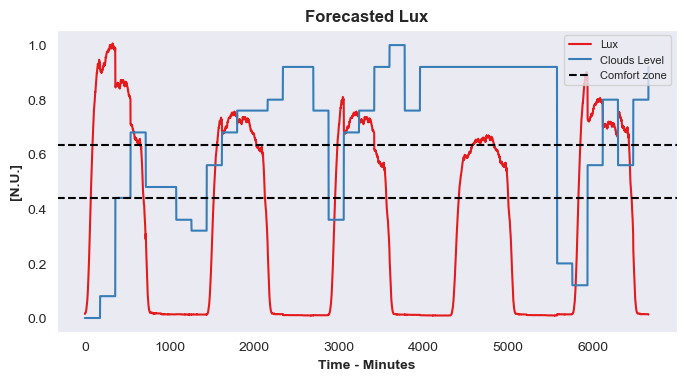

In [98]:
# VISUALIZE - final TEMPLATE with mov_range
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

data = forecast_merged

ax.plot(data.lux/1024, label='Lux')
ax.plot(forecast_merged.clouds_level/100, label='Clouds Level')

ax.axhline(450/1024, linestyle = '--', color='black', label = 'Comfort zone')
ax.axhline(650/1024, linestyle = '--', color='black')

ax.set_title('Forecasted Lux', fontweight = 'bold')

ax.set_xlabel("Time - Minutes", fontweight='bold')
ax.set_ylabel("[N.U.]", fontweight='bold')
ax.legend(loc = 'best', fontsize = 8)


plt.show()

In [99]:
dates = forecast_merged.date.unique()

# plan = [pd.DataFrame() for _ in range(len(dates))]
plan = []
df_super = pd.DataFrame()
for date in dates:
    
    df_input = forecast_merged[forecast_merged['date']==date]
    df_out = cost_daily(df_input, hours,
                        column = 'lux', 
                        date = date, 
                        curtains_level = res_tot.query('cost == cost.min()').params.values[0]['Curtains Level'], # 0.6, #
                        neon = res_tot.query('cost == cost.min()').params.values[0]['Neon'], # False, #
                        verbose = 0.5
                       )
    plan.append(df_out)
    
    df_super = pd.concat([df_super,
                          df_out[df_out.hour!='Total']\
                                                    .merge(forecast_merged[forecast_merged['date']==date],
                                                           on = ['date','hour'], how='right')\
                                                    .fillna(0)\
                                                    .sort_values('timestamp')\
                                                    .reset_index(drop = True)
                         ], axis = 0)

df_super.reset_index(drop = True, inplace = True)
df_super['modified_lux'] = df_super.lux * (1 - df_super.Curtains) + df_super.LED * 450


Total: 2.9174200439471836 - discomfort: 0.32, electricity: 1.50, investment led: 1.10 investment curtains: 0.00

Total: 2.934343501696608 - discomfort: 0.28, electricity: 1.56, investment led: 1.10 investment curtains: 0.00

Total: 2.924134561045946 - discomfort: 0.33, electricity: 1.50, investment led: 1.10 investment curtains: 0.00

Total: 2.7242446246504888 - discomfort: 0.07, electricity: 1.56, investment led: 1.10 investment curtains: 0.00

Total: 3.0199750956365987 - discomfort: 0.42, electricity: 1.50, investment led: 1.10 investment curtains: 0.00


### Scheduling for each day

In [100]:
for i in range(len(plan)):
    
    print(plan[i][['date','hour','params']])

          date   hour                                          params
0   2019-04-01      7  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
1   2019-04-01      8  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
2   2019-04-01      9  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
3   2019-04-01     10  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
4   2019-04-01     11  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
5   2019-04-01     12  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
6   2019-04-01     13  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
7   2019-04-01     14  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
8   2019-04-01     15  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
9   2019-04-01     16  {'Curtains': 0.6, 'LED': 0.5, 'Neon': 'False'}
10  2019-04-01     17    {'Curtains': 0.6, 'LED': 1, 'Neon': 'False'}
11  2019-04-01     18    {'Curtains': 0.6, 'LED': 1, 'Neon': 'False'}
12  2019-04-01     19    {'Curtains': 0.6, 'LED': 1, 'Neon': 'False'}
13  2019-04-01     2

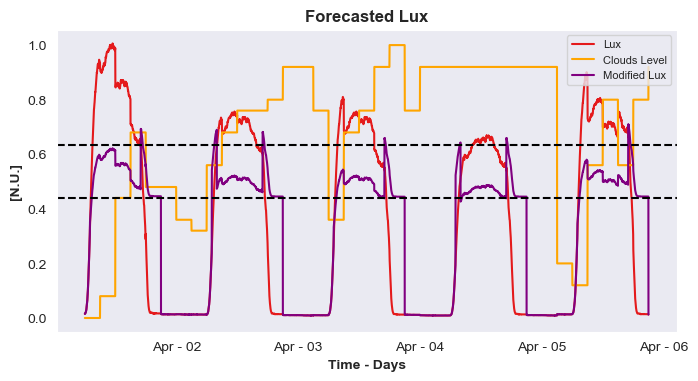

In [101]:
# VISUALIZE - final TEMPLATE with mov_range
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    
ax.plot(forecast_merged.timestamp, data.lux/1024, label='Lux')
ax.plot(forecast_merged.timestamp, forecast_merged.clouds_level/100, label='Clouds Level', color = 'orange')
ax.plot(df_super.timestamp, df_super['modified_lux']/1024, label='Modified Lux', color = 'purple')
ax.legend(loc = 'best', fontsize = 8)

# # Formatting xtick time labels
days_md = mdates.DayLocator(interval=1)
hours_md = mdates.HourLocator(interval=1, tz=None)
minutes_md = mdates.MinuteLocator(interval=5)

days_format = mdates.DateFormatter('%b - %d')
hours_format = mdates.DateFormatter('%H')
minute_format = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(days_md)
ax.xaxis.set_major_formatter(days_format)

ax.set_title('Forecasted Lux', fontweight = 'bold')

ax.axhline(450/1024, linestyle = '--', color='black')
ax.axhline(650/1024, linestyle = '--', color='black')

ax.set_xlabel("Time - Days", fontweight='bold')
ax.set_ylabel("[N.U.]", fontweight='bold')
ax.legend(loc = 'best', fontsize = 8)

plt.savefig('Modified Lux.png')

plt.show()